<a href="https://colab.research.google.com/github/matheusbuenowb/Data-Mining-Bee-Colony/blob/main/Analise_DaviAdaptado_IC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset UNSW NB15

- Contém pacotes de fluxo de rede com tráfego de atividades normais e comportamentos de ataques.
- São 9 tipos de ataques: Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms
- Possui 49 features e um rótulo
- Foi utilizado a ferramenta tcpdump para capturar os dados brutos do tráfego
- Um dos objetivos é conseguir criar um modelo de classificação que consiga categorizar os dados de forma precisa
- Link: https://research.unsw.edu.au/projects/unsw-nb15-dataset
- Aqui foi extraída uma amostra da base de dados completa, com aprox. 25% da totalidade

## Importação de bibliotecas e do dataset

In [ ]:
# manipulacao de dados
import pandas as pd
import numpy as np

# visualizacao de dados
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# pre-proc

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif

# metricas

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,silhouette_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

import time

### Carregamento do dataset

In [ ]:
df = pd.read_csv('/content/all_data_updated_att.csv')
#df_features = pd.read_csv('UNSW_NB15_features.csv', encoding='cp1252')

### Features e suas descrições

In [ ]:
df

,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
0,1,5,2022-06-08 14:52:28,36.42,30.29,1007.45,26.68,52,1013,8.75,...,0,37.29,-121.95,2022-06-08--14-52-28_1.raw,1,2,8,0,0.583,0
1,1,5,2022-06-08 15:51:41,33.56,33.98,1006.93,25.99,53,1012,10.29,...,0,37.29,-121.95,2022-06-08--15-51-41_1.raw,1,2,8,0,0.625,0
2,1,5,2022-06-08 17:21:53,29.01,42.73,1006.68,24.49,56,1012,8.75,...,0,37.29,-121.95,2022-06-08--17-21-53_1.raw,0,0,8,1,0.708,1
3,1,5,2022-06-08 18:20:59,30.51,36.74,1006.68,22.97,59,1012,8.23,...,0,37.29,-121.95,2022-06-08--18-20-59_1.raw,0,0,8,1,0.750,1
4,1,5,2022-06-08 19:20:04,30.32,35.55,1006.58,21.52,61,1012,7.20,...,0,37.29,-121.95,2022-06-08--19-20-04_1.raw,0,0,8,1,0.792,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,2,1,2022-07-15 11:18:39,50.84,11.99,1010.21,23.58,55,1015,2.57,...,0,37.29,-121.95,2022-07-15--11-18-39_2.raw,1,2,10,5,0.458,3
1271,2,1,2022-07-15 12:25:14,49.58,11.60,1009.81,25.60,51,1015,4.12,...,0,37.29,-121.95,2022-07-15--12-25-14_2.raw,1,2,10,5,0.500,3
1272,2,1,2022-07-15 13:25:58,45.83,15.36,1009.80,26.49,49,1015,5.14,...,0,37.29,-121.95,2022-07-15--13-25-58_2.raw,1,2,10,5,0.542,3
1273,2,1,2022-07-15 14:24:58,35.82,23.48,1009.26,27.33,46,1014,4.63,...,0,37.29,-121.95,2022-07-15--14-24-58_2.raw,1,2,10,5,0.583,3


### Concatenando headers

In [ ]:
df.columns = df_features['Name']
df

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,...,0,2,4,2,3,1,1,2,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,59.166.0.8,12520,149.171.126.6,31010,tcp,FIN,0.020383,320,1874,31,...,0,8,20,7,5,1,1,4,NaN,0
699996,59.166.0.0,18895,149.171.126.9,80,tcp,FIN,1.402957,19410,1087890,31,...,0,1,1,2,7,2,2,2,NaN,0
699997,59.166.0.0,30103,149.171.126.5,5190,tcp,FIN,0.007108,2158,2464,31,...,0,13,13,6,7,2,1,2,NaN,0
699998,59.166.0.6,30388,149.171.126.5,111,udp,CON,0.004435,568,304,31,...,0,10,13,6,5,1,1,3,NaN,0


## Pre-Proc Básico

Resumo estatístico

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   device            1275 non-null   int64  
 1   hive number       1275 non-null   int64  
 2   date              1275 non-null   object 
 3   hive temp         1275 non-null   float64
 4   hive humidity     1275 non-null   float64
 5   hive pressure     1275 non-null   float64
 6   weather temp      1275 non-null   float64
 7   weather humidity  1275 non-null   int64  
 8   weather pressure  1275 non-null   int64  
 9   wind speed        1275 non-null   float64
 10  gust speed        1275 non-null   float64
 11  weatherID         1275 non-null   int64  
 12  cloud coverage    1275 non-null   int64  
 13  rain              1275 non-null   int64  
 14  lat               1275 non-null   float64
 15  long              1275 non-null   float64
 16  file name         1275 non-null   object 


In [ ]:
# tipos de dados nas colunas

column_data_type = df.dtypes

# verificar dados numericos e categoricos
numer_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
categ_cols = df.select_dtypes(include=['object']).columns.to_list()

print(f"Colunas com dados numericos [{len(numer_cols)}]: {numer_cols}")
print(f"Colunas com dados categoricos [{len(categ_cols)}]: {categ_cols}")

Colunas com dados numericos [21]: ['device', 'hive number', 'hive temp', 'hive humidity', 'hive pressure', 'weather temp', 'weather humidity', 'weather pressure', 'wind speed', 'gust speed', 'weatherID', 'cloud coverage', 'rain', 'lat', 'long', 'queen presence', 'queen acceptance', 'frames', 'target', 'time', 'queen status']
Colunas com dados categoricos [2]: ['date', 'file name']


### Lidando com duplicados

In [ ]:
print(f"Dados duplicados: {df.duplicated().sum()}")

Dados duplicados: 0


In [ ]:
df = df.drop_duplicates()

### Lidando com Faltantes

In [ ]:
missing_data = df.isnull().sum().to_frame().rename(columns={0: 'Numero total de faltantes'})
missing_data['% de faltantes'] = round((missing_data['Numero total de faltantes']/len(df))*100,2)
missing_data

,Numero total de faltantes,% de faltantes
device,0,0.0
hive number,0,0.0
date,0,0.0
hive temp,0,0.0
hive humidity,0,0.0
hive pressure,0,0.0
weather temp,0,0.0
weather humidity,0,0.0
weather pressure,0,0.0
wind speed,0,0.0


#### Valor NaN indica que não houve ataque para os dados dessa linha. Portanto, substituir valores NaN na coluna ```'attack_cat'``` por ```'no_attack'```

In [ ]:
df = df.fillna('no_attack')

In [ ]:
df['attack_cat'] = df['attack_cat'].str.strip().str.lower()

In [ ]:
df['attack_cat'].unique()

array(['no_attack', 'exploits', 'reconnaissance', 'dos', 'generic',
       'shellcode', 'fuzzers', 'worms', 'backdoors', 'analysis'],
      dtype=object)

### Análise Descritiva em Numéricos e Categóricos

In [ ]:
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
dur,640791.0,6.500000e-01,1.919000e+01,0.000000e+00,0.000000e+00,3.000000e-02,3.200000e-01,8.786640e+03
sbytes,640791.0,4.924260e+03,4.504870e+04,0.000000e+00,5.120000e+02,2.048000e+03,3.806000e+03,1.367739e+07
dbytes,640791.0,4.398111e+04,1.719481e+05,0.000000e+00,3.040000e+02,3.380000e+03,2.187400e+04,1.465542e+07
sttl,640791.0,3.657000e+01,3.451000e+01,0.000000e+00,3.100000e+01,3.100000e+01,3.100000e+01,2.550000e+02
dttl,640791.0,3.254000e+01,3.029000e+01,0.000000e+00,2.900000e+01,2.900000e+01,2.900000e+01,2.540000e+02
sloss,640791.0,6.190000e+00,1.855000e+01,0.000000e+00,0.000000e+00,4.000000e+00,7.000000e+00,5.096000e+03
dloss,640791.0,1.975000e+01,5.987000e+01,0.000000e+00,0.000000e+00,5.000000e+00,1.600000e+01,5.483000e+03
Sload,640791.0,4.100124e+06,4.547474e+07,0.000000e+00,8.673325e+04,5.367647e+05,1.048276e+06,5.268000e+09
Dload,640791.0,3.082653e+06,4.534697e+06,0.000000e+00,9.278233e+04,6.742424e+05,3.918919e+06,1.287619e+08


In [ ]:
df[categ_cols].describe().T

,count,unique,top,freq
Name,,,,
srcip,640791,40,59.166.0.2,62850
sport,640791,100272,0,2981
dstip,640791,44,149.171.126.4,62883
dsport,640791,87819,53,98847
proto,640791,135,tcp,457028
state,640791,16,FIN,450611
service,640791,13,-,388573
attack_cat,640791,10,no_attack,626510


## Análise Exploratória dos Dados

### Checando e Lidando com Outliers

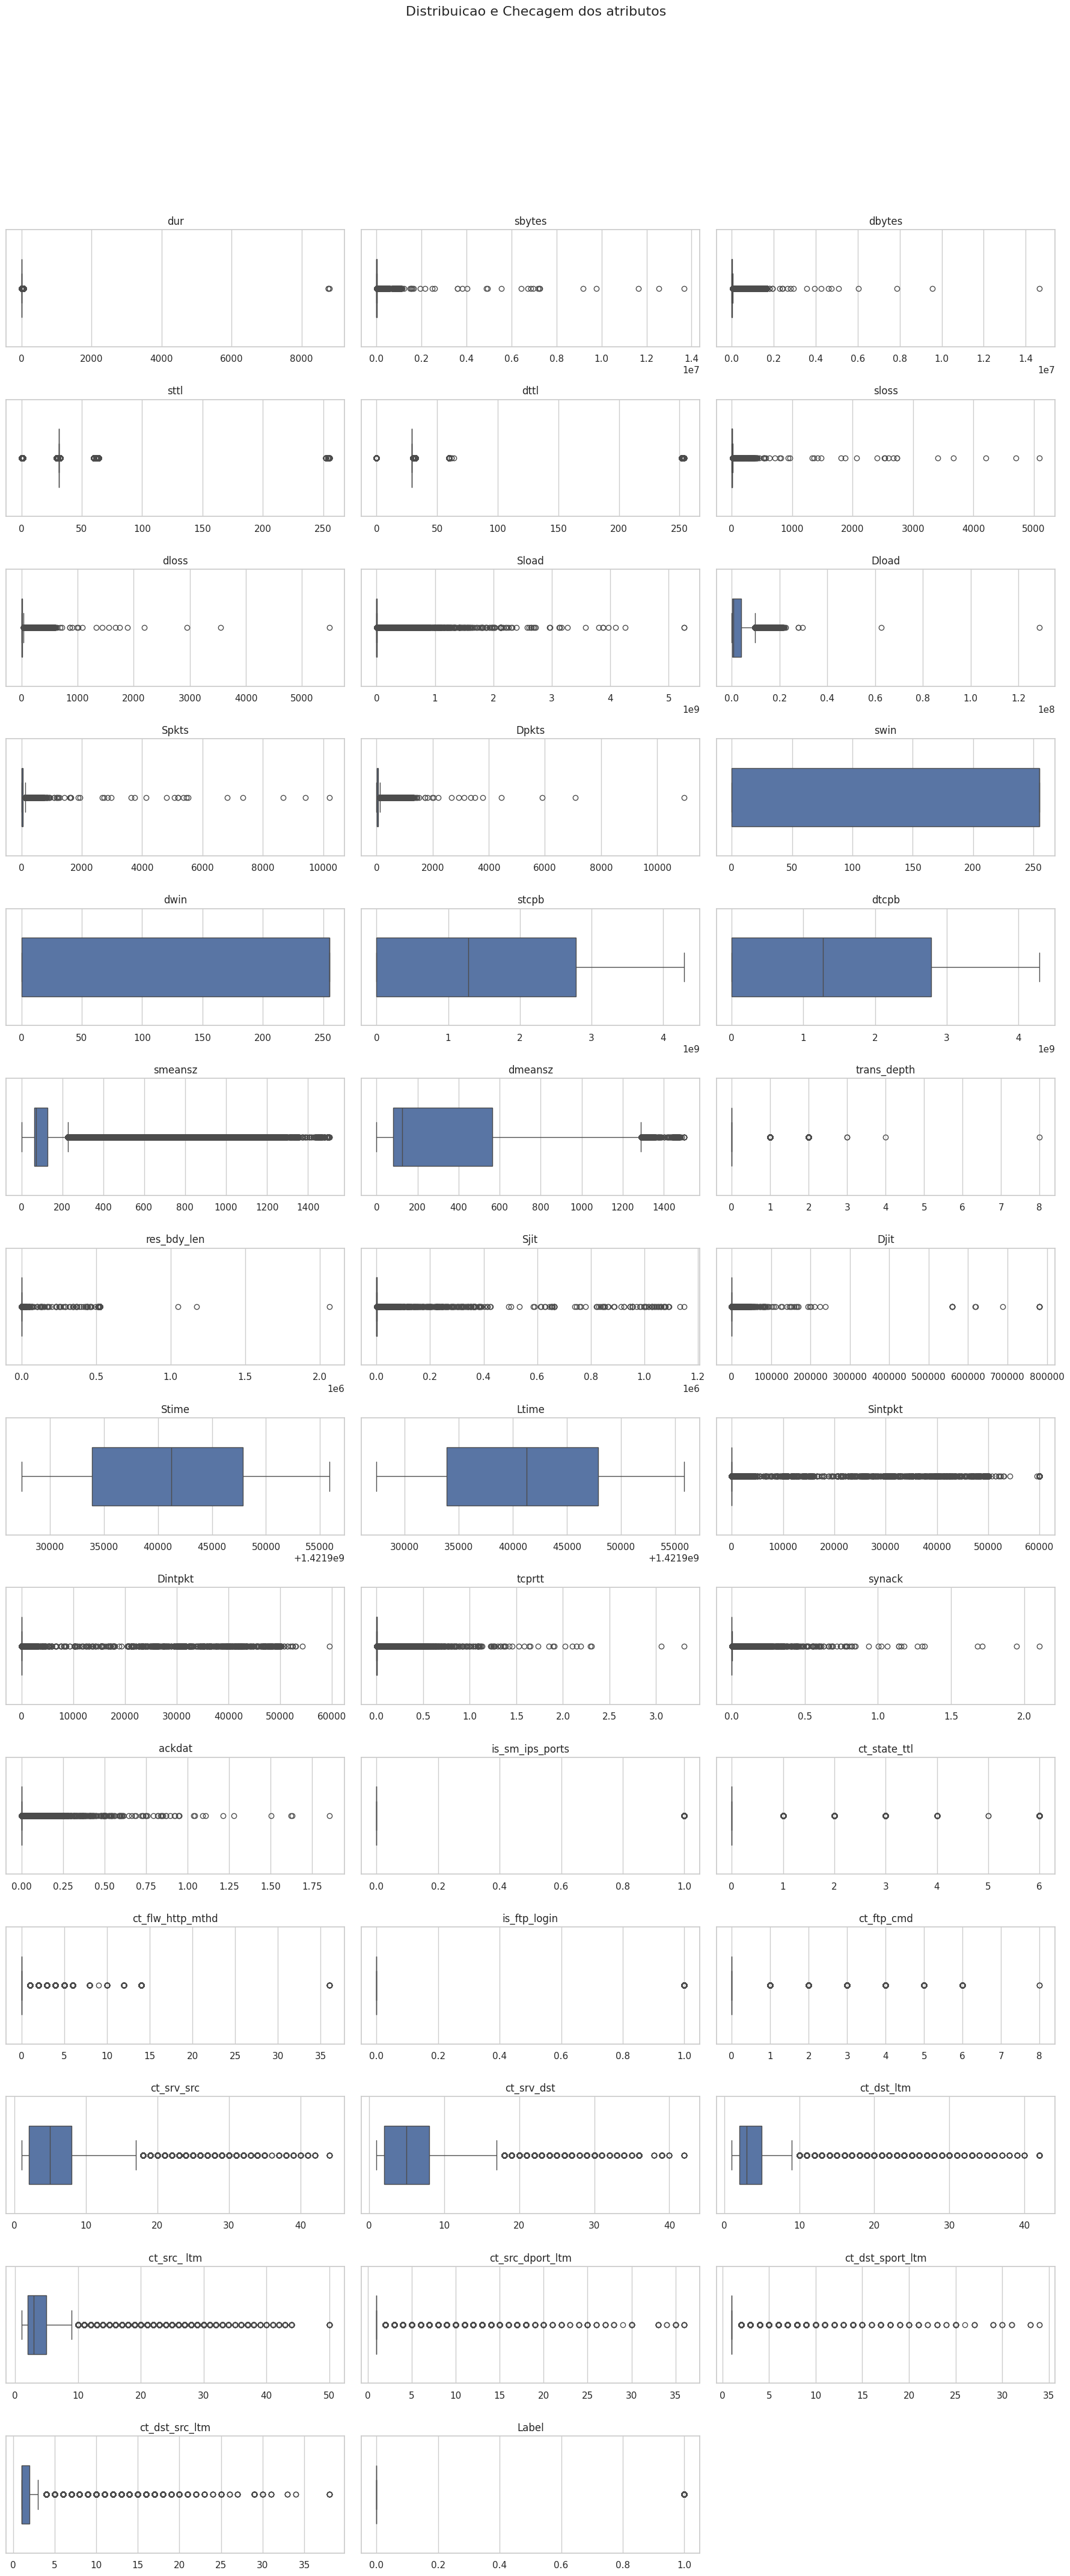

In [ ]:
import math

# dados para o plot
plot_rows = math.ceil(len(numer_cols) / 3)
plot_cols = 3

plt.figure(figsize=(18, plot_rows * 3))

sns.set_palette('husl')
sns.set(style='whitegrid')

# iterando e plotando as colunas numericas
for i, col in enumerate(numer_cols, 1):
  plt.subplot(plot_rows, plot_cols, i)
  sns.boxplot(x=df[col], width=0.5)
  plt.title(col)
  plt.xlabel('')

plt.suptitle('Distribuicao e Checagem dos atributos', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Possível solução: aplicar valores médios para os outliers caso passe de determinado limite

In [ ]:
# desconsiderar colunas que possuem valores não relevantes
exclude_cols = ['sport', 'swin', 'dwin', 'stcpb', 'dtcpb', 'Stime', 'Ltime']

# filtrando as colunas
numeric_columns = [c for c in numer_cols if c not in exclude_cols]

In [ ]:
for col in numeric_columns:
  media = df[col].median()
  # calculos dos limites utilizando o metodo IQR
  # 1.5 eh usado como regra para identificar outliers
  lower_bound = df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))
  upper_bound = df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))

  outlier_condition = (df[col] < lower_bound) | (df[col] > upper_bound)
  df[col] = np.where(outlier_condition, media, df[col])

### Distribuição dos dados e assimetria/distorção (skewness)

`Skewness < 1` => distribuição aprox. simétrica <br>
`Skewness > 1` => distribuição bastante assimétrica <br>
`1 < Skewness < 2` => distribuição moderadamente assimétrica


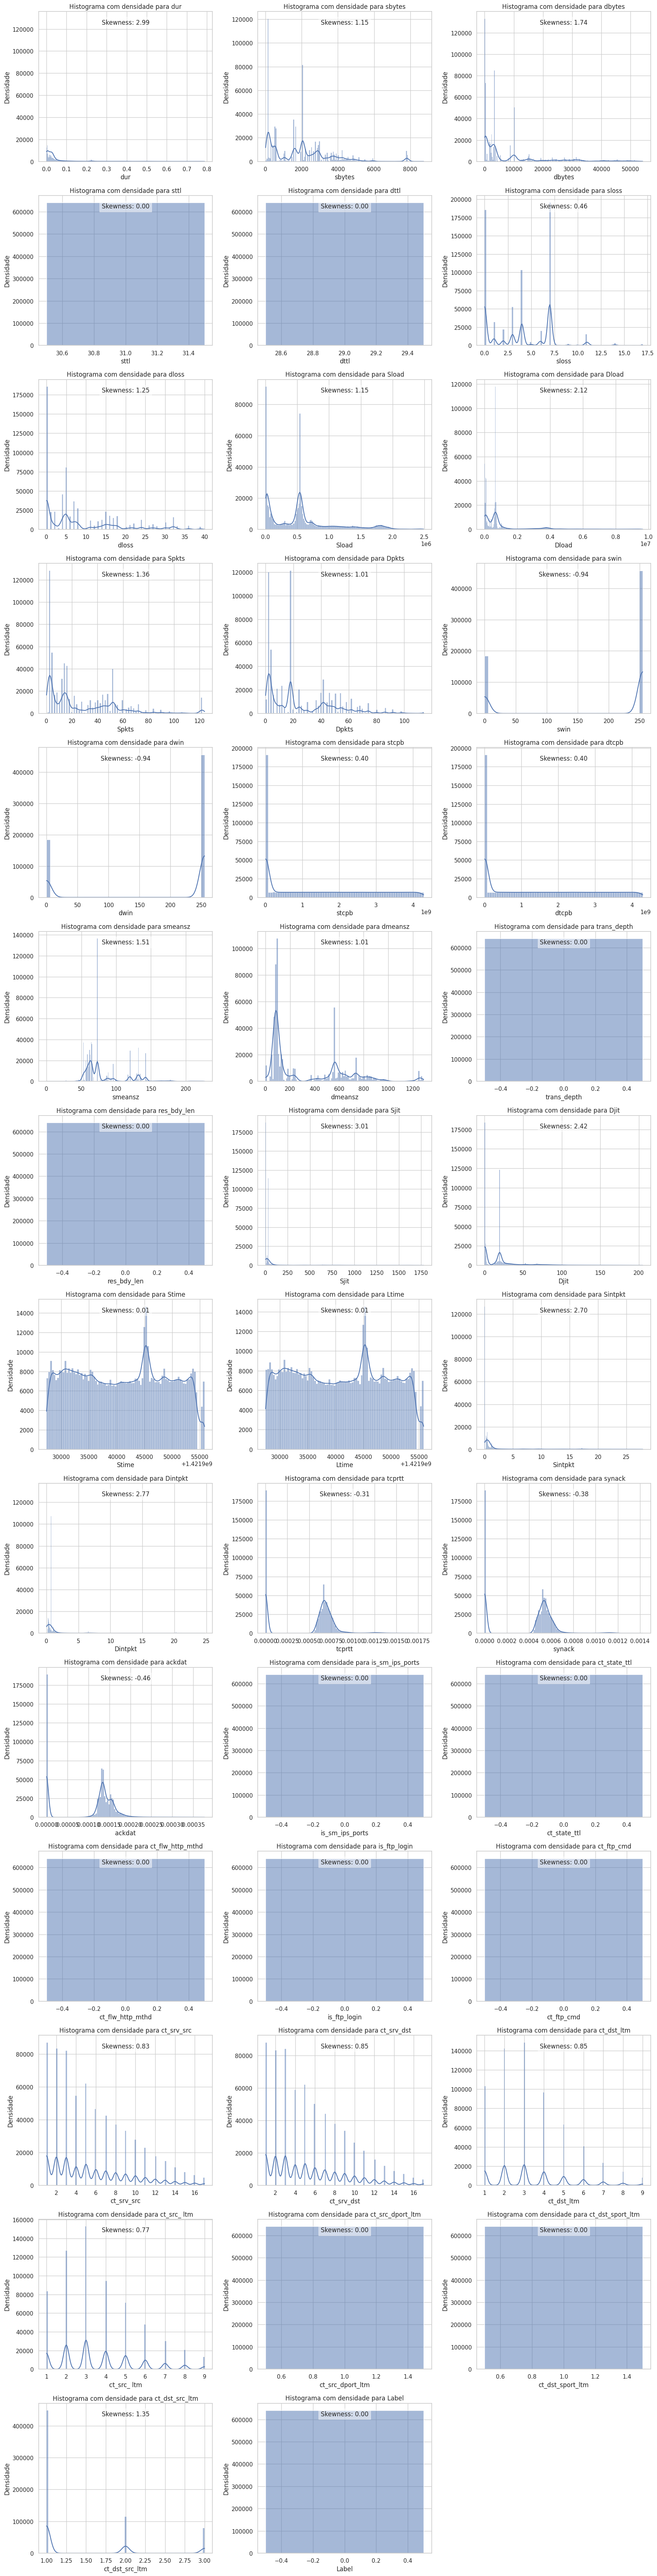

In [ ]:
# calculo para manter os plots com tamanho adequado
n_features = len(numer_cols)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig = plt.figure(figsize=(18, n_rows*5))

# iterar e criar histogramas com densidade
for i, col in enumerate(numer_cols, 1):

  plt.subplot(n_rows, n_cols, i)

  sns.histplot(data=df, x=col, kde=True)

  plt.title(f'Histograma com densidade para {col}')
  plt.xlabel(col)
  plt.ylabel('Densidade')

  skewness = df[col].skew()
  plt.text(0.5, 0.95, f'Skewness: {skewness:.2f}',
           transform=plt.gca().transAxes,
           ha='center',
           va='top',
           bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

#### Normalização dos dados numéricos

- Transformação logarítmica ajuda na normalização <br>
- Deixa os dados mais adequados para implementação de ML <br>
- Melhora no desempenho dos modelos de forma geral

In [ ]:
def transform_df(df):
  # var para evitar log0
  eps = 1e-5

  numeric_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()

  for col in numeric_cols:
    skewness = df[col].skew()

    if skewness > 0: # cauda longa na direita
      df[col] = np.log(df[col] + eps)

    elif skewness < 0: # cauda longa na esquerda
      df[col] = np.log(np.max(X[col] + eps) - X[col] + eps)

    else: # dados simetricos, sem mudanca
      df[col] = df[col]

    return df

In [ ]:
transform_df(df)

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,-3.320272,528.0,304.0,31.0,...,0.0,2.0,4.0,2.0,3.0,1.0,1.0,2.0,no_attack,0.0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,-6.786423,146.0,178.0,31.0,...,0.0,12.0,8.0,1.0,2.0,1.0,1.0,1.0,no_attack,0.0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,-6.709724,132.0,164.0,31.0,...,0.0,6.0,9.0,1.0,1.0,1.0,1.0,1.0,no_attack,0.0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,-6.743089,146.0,178.0,31.0,...,0.0,7.0,9.0,1.0,1.0,1.0,1.0,1.0,no_attack,0.0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,-2.546582,568.0,312.0,31.0,...,0.0,2.0,4.0,2.0,3.0,1.0,1.0,2.0,no_attack,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,59.166.0.8,12520,149.171.126.6,31010,tcp,FIN,-3.892564,320.0,1874.0,31.0,...,0.0,8.0,5.0,7.0,5.0,1.0,1.0,1.0,no_attack,0.0
699996,59.166.0.0,18895,149.171.126.9,80,tcp,FIN,-3.603767,2048.0,3380.0,31.0,...,0.0,1.0,1.0,2.0,7.0,1.0,1.0,2.0,no_attack,0.0
699997,59.166.0.0,30103,149.171.126.5,5190,tcp,FIN,-4.945128,2158.0,2464.0,31.0,...,0.0,13.0,13.0,6.0,7.0,1.0,1.0,2.0,no_attack,0.0
699998,59.166.0.6,30388,149.171.126.5,111,udp,CON,-5.415975,568.0,304.0,31.0,...,0.0,10.0,13.0,6.0,5.0,1.0,1.0,3.0,no_attack,0.0


### Visualização de distribuição de classes

In [ ]:
def plot_class_distribution(df, class_column, title="Distribuição de classes", figsize=(8, 8)):
    """
    Creates a pie chart showing the distribution of classes in a DataFrame.

    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame containing the data
    class_column : str
        The name of the column containing class labels
    title : str, optional
        The title of the pie chart
    figsize : tuple, optional
        The size of the figure (width, height)
    """

    # Calculate class distribution
    class_counts = df[class_column].value_counts()

    # Calculate percentages
    total = len(df)
    percentages = [(count/total)*100 for count in class_counts]

    # Create labels with both count and percentage
    labels = [f'{label}: {count} ({percentage:.2f}%)'
             for label, count, percentage in zip(class_counts.index, class_counts, percentages)]

    fig, ax = plt.subplots(figsize=figsize)

    # Create pie chart
    wedges, texts, autotexts = ax.pie(class_counts,
                                     labels=[''] * len(class_counts),  # Empty labels for the pie
                                     autopct='',
                                     startangle=90,
                                     shadow=False)

    # Add legend outside of pie
    ax.legend(wedges, labels,
             title="Classes",
             loc="center left",
             bbox_to_anchor=(1, 0, 0.5, 1))

    # Add title
    plt.title(title, size=14)

    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')
    plt.tight_layout()

    # Show the plot
    plt.show()

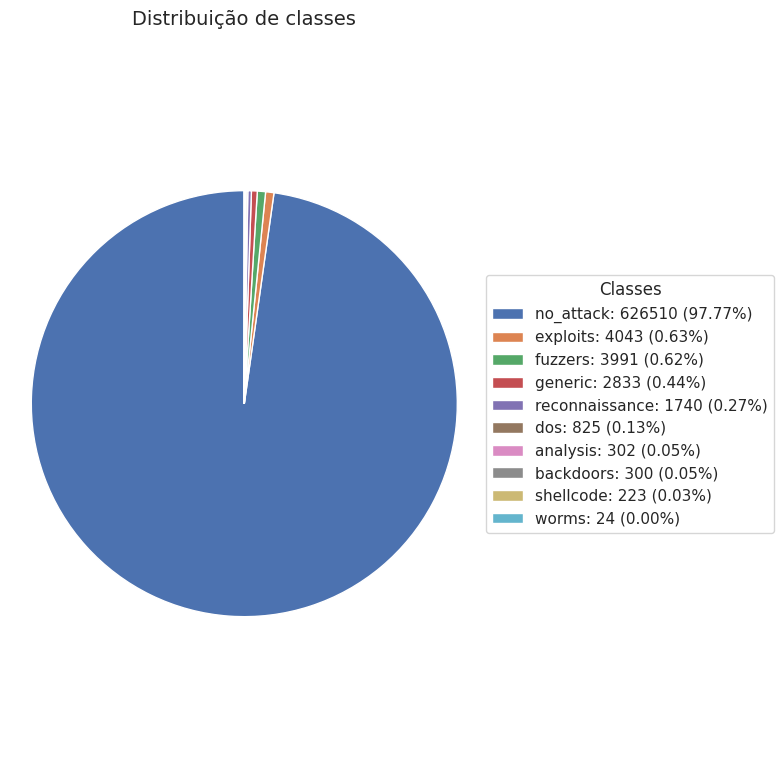

In [ ]:
plot_class_distribution(df, 'attack_cat')

## Pré-Processamento

### Engenharia de Features

#### Geração de features

Criação de features como `razoes`, `agregacoes`, `estatisticas` e `interacao`

In [ ]:
def generate_features(df):

  # proporcoes - razao de valores de origem e destino
  df['byte_ratio'] = df['sbytes'] / (df['dbytes'] + 1)
  df['pkt_ratio'] = df['Spkts'] / (df['Dpkts'] + 1)
  df['load_ratio'] = df['Sload'] / (df['Dload'] + 1)
  df['jit_ratio'] = df['Sjit'] / (df['Djit'] + 1)
  df['inter_pkt_ratio'] = df['Sintpkt'] / (df['Dintpkt'] + 1)
  df['tcp_setup_ratio'] = df['tcprtt'] / (df['synack'] + df['ackdat'] + 1)

  # agregacao - soma de valores de destino e origem
  df['total_bytes'] = df['sbytes'] + df['dbytes']
  df['total_pkts'] = df['Spkts'] + df['Dpkts']
  df['total_load'] = df['Sload'] + df['Dload']
  df['total_jitter'] = df['Sjit'] + df['Djit']
  df['total_inter_pkt'] = df['Sintpkt'] + df['Dintpkt']
  df['total_tcp_setup'] = df['tcprtt'] + df['synack'] + df['ackdat']

  # interacao (bytes com pkt), (load com jitter), (pkt com jitter)
  df['byte_pkt_interaction_src'] = df['sbytes'] * df['Spkts']
  df['byte_pkt_interaction_dst'] = df['dbytes'] * df['Dpkts']
  df['load_jit_interaction_src'] = df['Sload'] * df['Sjit']
  df['load_jit_interaction_dst'] = df['Dload'] * df['Djit']
  df['pkt_jit_interaction_src'] = df['Spkts'] * df['Sjit']
  df['pkt_jit_interaction_dst'] = df['Dpkts'] * df['Djit']

  # estatistico
  df['mean_pkt_size'] = df['smeansz'] + df['dmeansz'] # tamanho medio de pkt
  df['tcp_seq_diff'] = df['stcpb'] - df['dtcpb'] # diferenca do num de sequencia do tcp

  return df

In [ ]:
generate_features(df)

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,total_inter_pkt,total_tcp_setup,byte_pkt_interaction_src,byte_pkt_interaction_dst,load_jit_interaction_src,load_jit_interaction_dst,pkt_jit_interaction_src,pkt_jit_interaction_dst,mean_pkt_size,tcp_seq_diff
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,-3.320272,528.0,304.0,31.0,...,14.569333,0.000000,2112.0,1216.0,8.672050e+05,5.392662e+05,39.564040,42.730932,208.0,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,-6.786423,146.0,178.0,31.0,...,0.030000,0.000000,292.0,356.0,0.000000e+00,0.000000e+00,0.000000,0.000000,162.0,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,-6.709724,132.0,164.0,31.0,...,0.057000,0.000000,264.0,328.0,0.000000e+00,0.000000e+00,0.000000,0.000000,148.0,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,-6.743089,146.0,178.0,31.0,...,0.008000,0.000000,292.0,356.0,0.000000e+00,0.000000e+00,0.000000,0.000000,162.0,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,-2.546582,568.0,312.0,31.0,...,45.318000,0.000000,2272.0,1248.0,1.291273e+06,8.213185e+05,118.728884,137.481360,220.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,59.166.0.8,12520,149.171.126.6,31010,tcp,FIN,-3.892564,320.0,1874.0,31.0,...,6.034829,0.001376,1920.0,14992.0,2.230112e+07,1.981997e+06,1276.864374,24.633560,287.0,-16799689
699996,59.166.0.0,18895,149.171.126.9,80,tcp,FIN,-3.603767,2048.0,3380.0,31.0,...,5.746449,0.001424,32768.0,60840.0,2.249608e+07,7.073166e+08,3260.942400,2055.124584,178.0,-2146440057
699997,59.166.0.0,30103,149.171.126.5,5190,tcp,FIN,-4.945128,2158.0,2464.0,31.0,...,0.559739,0.001314,51792.0,59136.0,4.104894e+07,1.150080e+06,423.067944,10.382856,193.0,-2145666685
699998,59.166.0.6,30388,149.171.126.5,111,udp,CON,-5.415975,568.0,304.0,31.0,...,2.153000,0.000000,2272.0,1216.0,1.259157e+06,5.719353e+05,6.554416,5.562572,218.0,0


#### Codificação do target

In [ ]:
drop_cols = ['sport', 'dsport', 'proto', 'srcip', 'dstip', 'state', 'service', 'Label']
df.drop(columns=drop_cols, inplace=True)

In [ ]:
df.select_dtypes(include=['object']).columns.tolist()

['attack_cat']

In [ ]:
label_encoder = LabelEncoder()
ohe = OneHotEncoder()

In [ ]:
df['attack_cat'] = label_encoder.fit_transform(df['attack_cat'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_,
                         label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'analysis': np.int64(0), 'backdoors': np.int64(1), 'dos': np.int64(2), 'exploits': np.int64(3), 'fuzzers': np.int64(4), 'generic': np.int64(5), 'no_attack': np.int64(6), 'reconnaissance': np.int64(7), 'shellcode': np.int64(8), 'worms': np.int64(9)}


#### Verificando Correlação de features

<Axes: title={'center': 'Correlacao de atributos'}, xlabel='Name', ylabel='Name'>

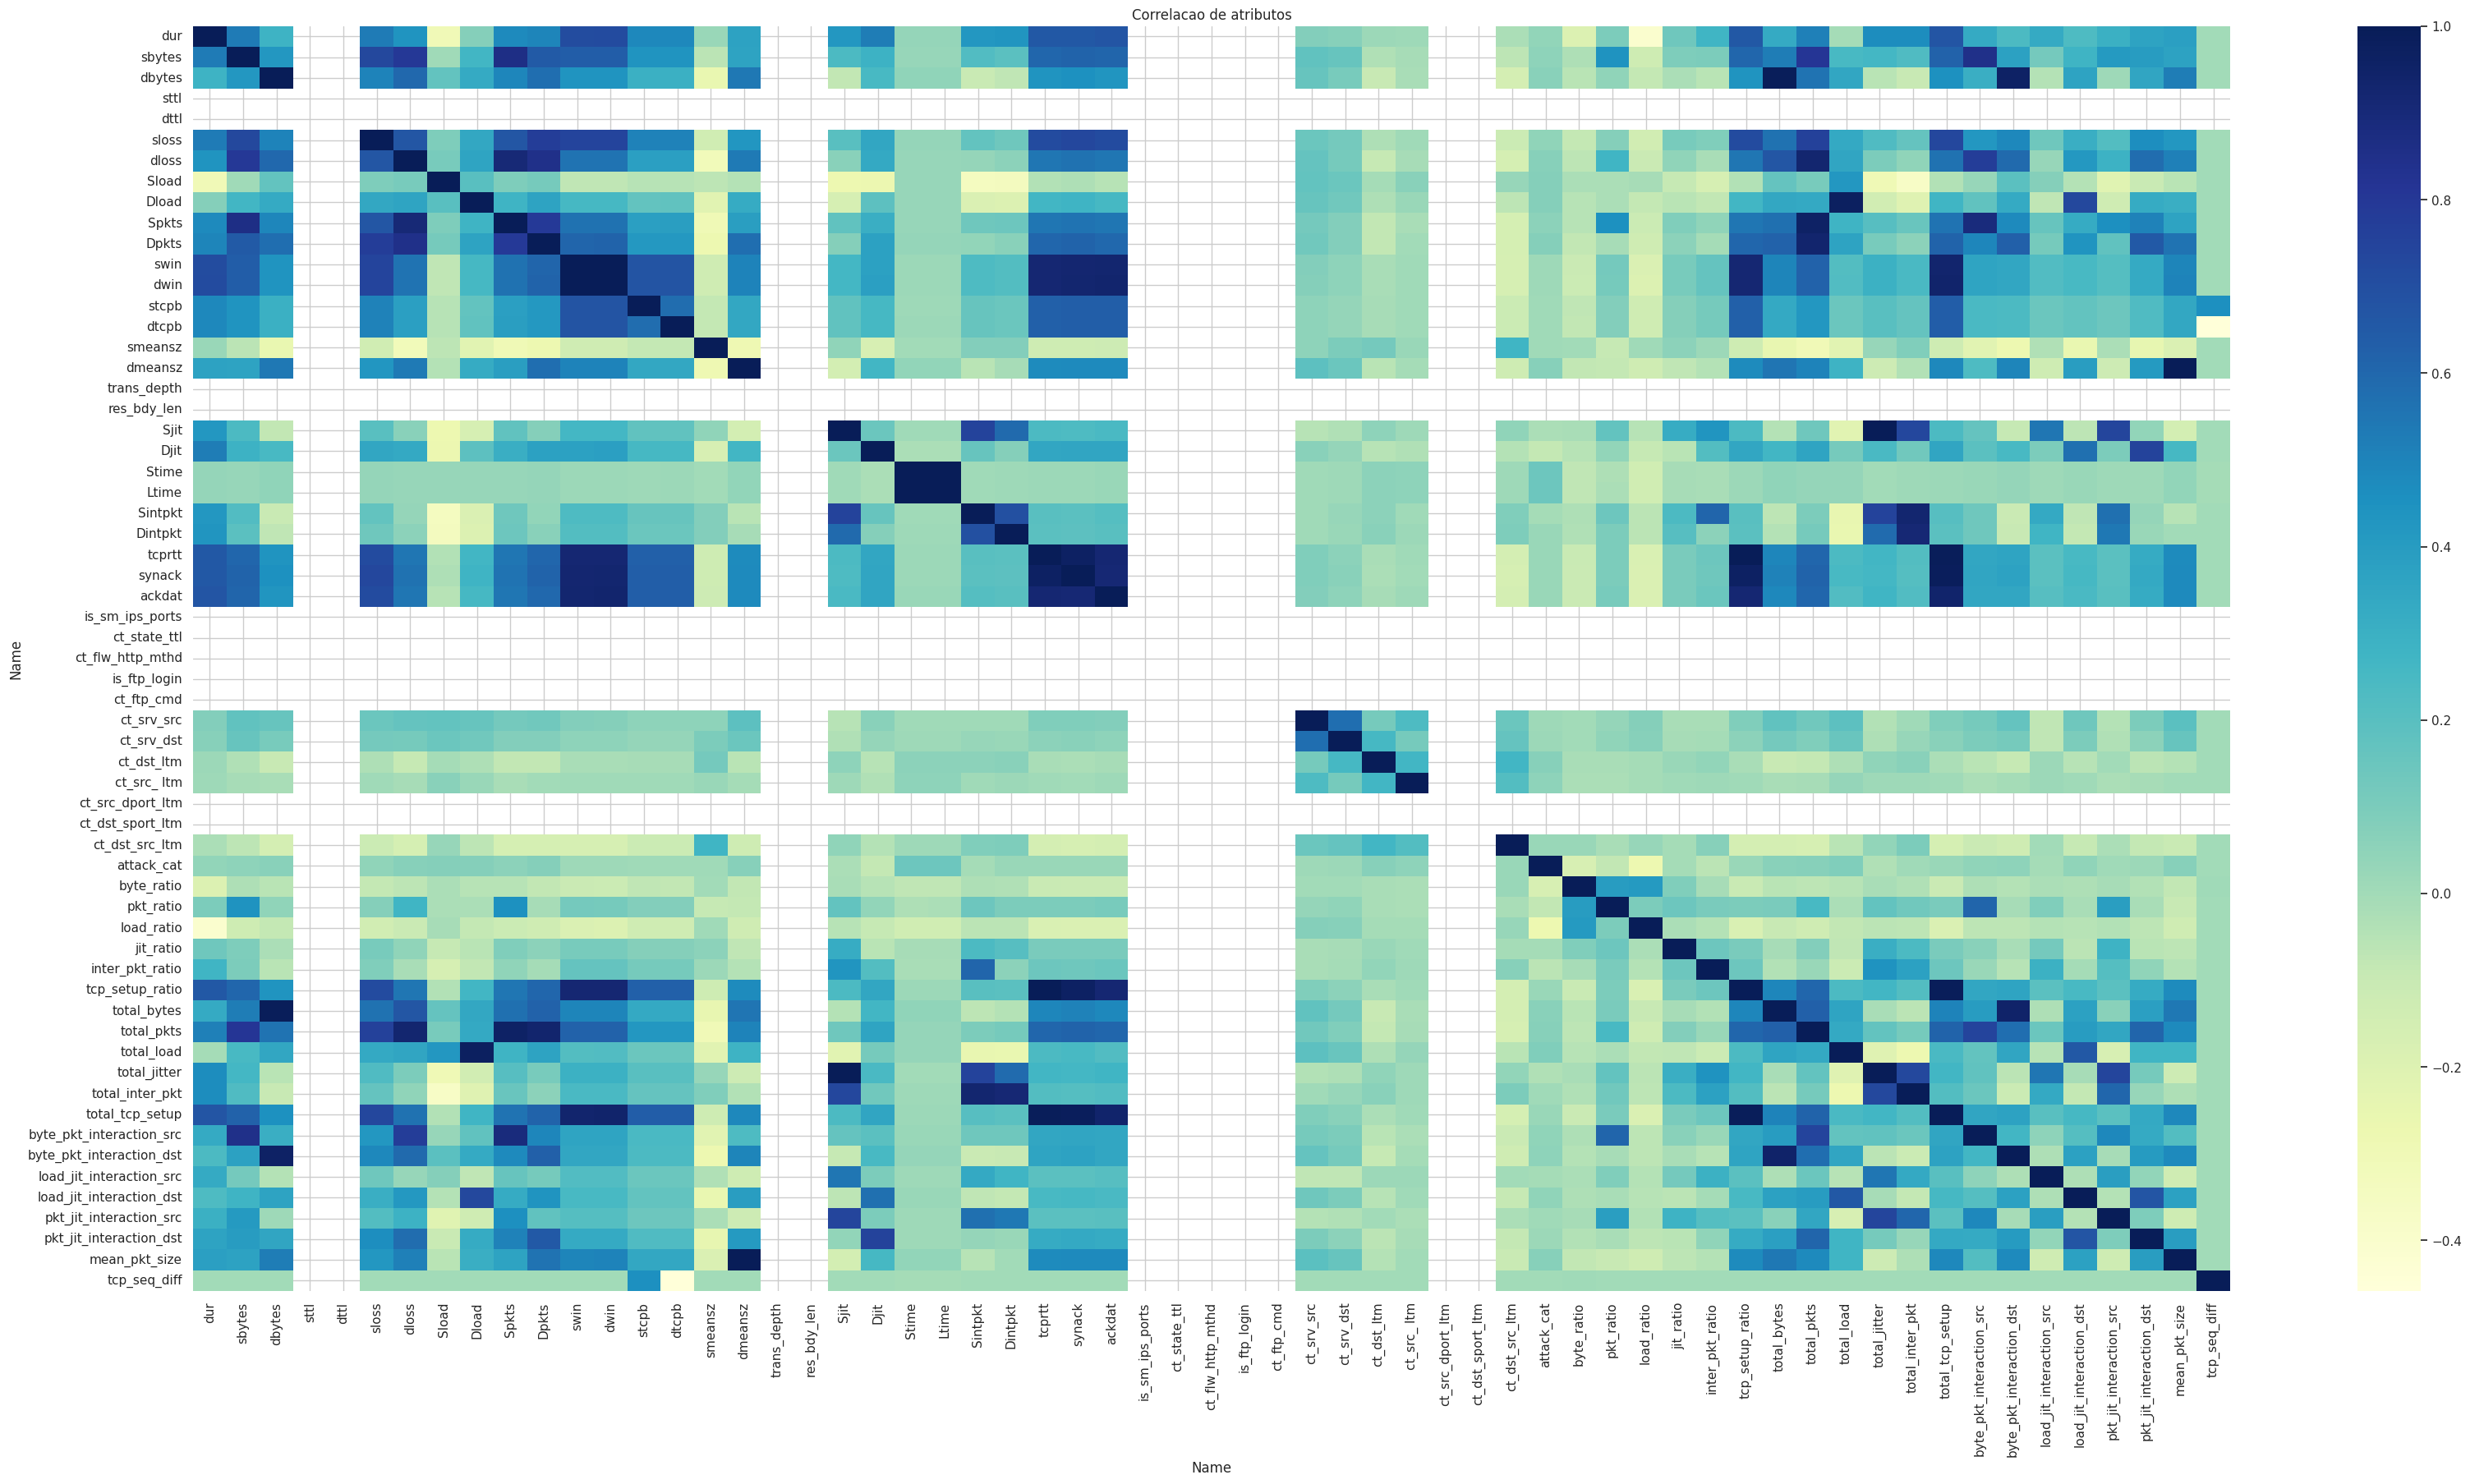

In [ ]:
plt.figure(figsize=(40,20))
plt.title("Correlacao de atributos")

sns.heatmap(df.corr(), cmap='YlGnBu')

In [ ]:
corr_matrix = df.corr()

# identificar features com coef de corr >= 0.75
limit = 0.75

highly_correlated = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
      # se coef for > 0.75
        if abs(corr_matrix.iloc[i, j]) >= limit:
            highly_correlated.append(
                (corr_matrix.index[i],
                  corr_matrix.columns[j],
                  corr_matrix.iloc[i, j])
            )

print(f"Features com alta correlacao (|correlation| >= {limit}):\n")
for feat1, feat2, corr in highly_correlated:
    print(f"{feat1} -- {feat2}: {corr:.3f}")

Features com alta correlacao (|correlation| >= 0.75):

dloss -- sbytes: 0.798
Spkts -- sbytes: 0.863
Spkts -- dloss: 0.907
Dpkts -- sloss: 0.776
Dpkts -- dloss: 0.852
Dpkts -- Spkts: 0.793
dwin -- swin: 0.997
Ltime -- Stime: 1.000
Sintpkt -- Sjit: 0.752
tcprtt -- swin: 0.917
tcprtt -- dwin: 0.920
synack -- swin: 0.924
synack -- dwin: 0.927
synack -- tcprtt: 0.966
ackdat -- swin: 0.932
ackdat -- dwin: 0.934
ackdat -- tcprtt: 0.919
ackdat -- synack: 0.914
tcp_setup_ratio -- swin: 0.917
tcp_setup_ratio -- dwin: 0.920
tcp_setup_ratio -- tcprtt: 1.000
tcp_setup_ratio -- synack: 0.966
tcp_setup_ratio -- ackdat: 0.919
total_bytes -- dbytes: 0.993
total_pkts -- sbytes: 0.809
total_pkts -- sloss: 0.756
total_pkts -- dloss: 0.931
total_pkts -- Spkts: 0.956
total_pkts -- Dpkts: 0.937
total_load -- Dload: 0.973
total_jitter -- Sjit: 0.995
total_jitter -- Sintpkt: 0.753
total_inter_pkt -- Sintpkt: 0.928
total_inter_pkt -- Dintpkt: 0.913
total_tcp_setup -- swin: 0.935
total_tcp_setup -- dwin: 0.938


#### **TODO**: Verificar desempenho com e sem drop de features altamente correlacionados

### Preparo para modelação

#### Separando features em sets de teste e treino

In [ ]:
def split_features(df, target_column, test_size=0.2, random_state=42):
  """
    Split dataset into dependent and independent features, then into train and test sets.

    Parameters:
    -----------
    df : pandas DataFrame
        Input DataFrame
    target_column : str
        Name of the target (dependent) variable
    test_size : float
        Proportion of dataset to include in the test split (default: 0.2)
    random_state : int
        Random state for reproducibility (default: 42)

    Returns:
    --------
    X_train, X_test, y_train, y_test : numpy arrays or pandas DataFrames
        Splits of independent and dependent variables
    """

  # separar features e target
  X = df.drop(target_column, axis=1) # indep
  y = df[target_column] # dep

  X_train, X_test, y_train, y_test = train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
      stratify=y
  )

  # Print shapes for verification
  print("Training set shapes:")
  print(f"X_train: {X_train.shape}")
  print(f"y_train: {y_train.shape}")
  print("\nTesting set shapes:")
  print(f"X_test: {X_test.shape}")
  print(f"y_test: {y_test.shape}")

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_features(df, 'attack_cat')

Training set shapes:
X_train: (512632, 60)
y_train: (512632,)

Testing set shapes:
X_test: (128159, 60)
y_test: (128159,)


#### Realizando o Scaling dos dados

In [ ]:
class DataScaler:
  def __init__(self, method='standard'):
    """
        Initialize scaler based on method.

        Parameters:
        -----------
        method : str
            Scaling method ('standard', 'minmax', or 'robust')
    """

    self.method = method
    if method == 'standard':
        self.scaler = StandardScaler()
    elif method == 'minmax':
        self.scaler = MinMaxScaler()
    # elif method == 'robust':
    #     self.scaler = RobustScaler()
    else:
        raise ValueError("Method must be 'standard', 'minmax', or 'robust'")

  def fit_transform(self, X_train, X_test=None):
    X_train_scaled = pd.DataFrame(
          self.scaler.fit_transform(X_train),
          columns=X_train.columns,
          index=X_train.index
      )

    if X_test is not None:
      X_test_scaled = pd.DataFrame(
          self.scaler.transform(X_test),
          columns=X_test.columns,
          index=X_test.index
      )
      return X_train_scaled, X_test_scaled

    return X_train_scaled

  def inverse_transform(self, X_scaled):
    """
    Inverse transform scaled data back to original scale.
    """
    return pd.DataFrame(
        self.scaler.inverse_transform(X_scaled),
        columns=X_scaled.columns,
        index=X_scaled.index
    )

In [ ]:
def visualize_scaling(original_data, scaled_data, title_ori='Dados originais', title_scaled="Dados Scaled"):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 5))

  # dados originais
  sns.boxplot(data=original_data, ax=ax1)
  ax1.set_title(title_ori)
  ax1.tick_params(axis='x', rotation=45)

  # dados scaled
  sns.boxplot(data=scaled_data, ax=ax2)
  ax2.set_title(title_scaled)
  ax2.tick_params(axis='x', rotation=45)

  plt.tight_layout()
  plt.show()

In [ ]:
def scale_data(X_train, X_test, scaling_method='standard'):

  scaler = DataScaler(method=scaling_method)

  X_train_scaled, X_test_scaled = scaler.fit_transform(X_train, X_test)

  # visualize_scaling(X_train, X_train_scaled)

  return X_train_scaled, X_test_scaled



In [ ]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

#### Aplicando balanceamento dos dados

In [ ]:
def visualize_class_distribution(y, title="Class Distribution"):
    """
    Visualize the distribution of classes in the target variable.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

    # Print class distribution
    print("\nClass Distribution:")
    print(pd.Series(y).value_counts(normalize=True).multiply(100).round(2))

In [ ]:
from collections import Counter

def apply_smote(X, y, sampling_strategy='auto', k_neighbors=5):
    """
    Apply SMOTE to balance the dataset.

    Parameters:
    -----------
    X : array-like
        Feature matrix
    y : array-like
        Target variable
    sampling_strategy : str or dict
        Sampling strategy ('auto' or dict with desired ratios)

    Returns:
    --------
    X_resampled, y_resampled : arrays
        Balanced feature matrix and target variable
    """

    desired_count = 18000

    # if #samples < desired, increase them
    oversample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] < desired_count}

    # if #samples > desired, decrease them
    undersample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] > desired_count}

    # Print original class distribution
    print("Original class distribution:")
    print(Counter(y))
    # visualize_class_distribution(y)

    # Apply SMOTE
    smote = SMOTE(
        random_state=42,
        sampling_strategy=oversample_strategy,
        k_neighbors=k_neighbors
    )
    # apply random undSamp
    undersample = RandomUnderSampler(sampling_strategy=undersample_strategy)

    # combine balancing tecniques in a pipeline
    pipeline = Pipeline(steps=[('smote', smote), ('undersample', undersample)])

    X_resampled, y_resampled = pipeline.fit_resample(X, y)

    # Print new class distribution
    print("\nResampled class distribution:")
    print(Counter(y_resampled))
    # visualize_class_distribution(y_resampled)

    return X_resampled, y_resampled

In [ ]:
X_train_resampled, y_train_resampled = apply_smote(X_train_scaled, y_train)

Original class distribution:
Counter({6: 501207, 3: 3234, 4: 3193, 5: 2266, 7: 1392, 2: 660, 0: 242, 1: 240, 8: 179, 9: 19})

Resampled class distribution:
Counter({0: 18000, 1: 18000, 2: 18000, 3: 18000, 4: 18000, 5: 18000, 6: 18000, 7: 18000, 8: 18000, 9: 18000})


#### Verificação de Importância de Features com *Mutual Information Score*

In [ ]:
class MutualInformationScore:
  def __init__(self):
    self.problem_type = 'classif'
    self.mi_func = mutual_info_classif


  def calc_mi_scores(self, X, y):

    mi_scores = self.mi_func(X, y)

    mi_df = pd.DataFrame({'Feature': X.columns,
                          'MI_Score': mi_scores})

    mi_df = mi_df.sort_values('MI_Score', ascending=False)

    return mi_df


  def plot_mi_scores(self, mi_df, figsize=(12, 10)):
    """
    Plot mutual information scores.
    """
    plt.figure(figsize=figsize)

    # Create bar plot
    sns.barplot(data=mi_df, x='MI_Score', y='Feature', width=0.4)

    plt.title('Feature Importance using Mutual Information')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')

    plt.tight_layout()
    plt.show()


  def plot_feature_relationships(self, X, y, top_n=5):
    """
    Plot relationships between top features and target.

    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series
        Target variable
    top_n : int
        Number of top features to plot
    """
    # Get MI scores
    mi_df = self.calc_mi_scores(X, y)
    top_features = mi_df.head(top_n)['Feature'].tolist()

    # Create subplot grid
    n_cols = 2
    n_rows = (top_n + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
    axes.margins(x=0.8)
    axes = axes.ravel()

    for idx, feature in enumerate(top_features):
      if self.problem_type == 'classif':
        # For classification, use box plots
        sns.boxplot(data=X, x=y, y=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature} vs Target')

    # Remove empty subplots
    for idx in range(len(top_features), len(axes)):
      fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_mutual_information(X, y, top_n=10, plot=True):
  """
  Comprehensive mutual information analysis.

  Parameters:
  -----------
  top_n : int
      Number of top features to analyze
  plot : bool
      Whether to create visualizations
  """

  # Initialize analyzer
  analyzer = MutualInformationScore()

  # Calculate MI scores
  mi_scores = analyzer.calc_mi_scores(X, y)

  if plot:
    # Plot MI scores
    analyzer.plot_mi_scores(mi_scores)

    # Plot relationships for top features
    # analyzer.plot_feature_relationships(X, y, top_n=top_n)

  return mi_scores

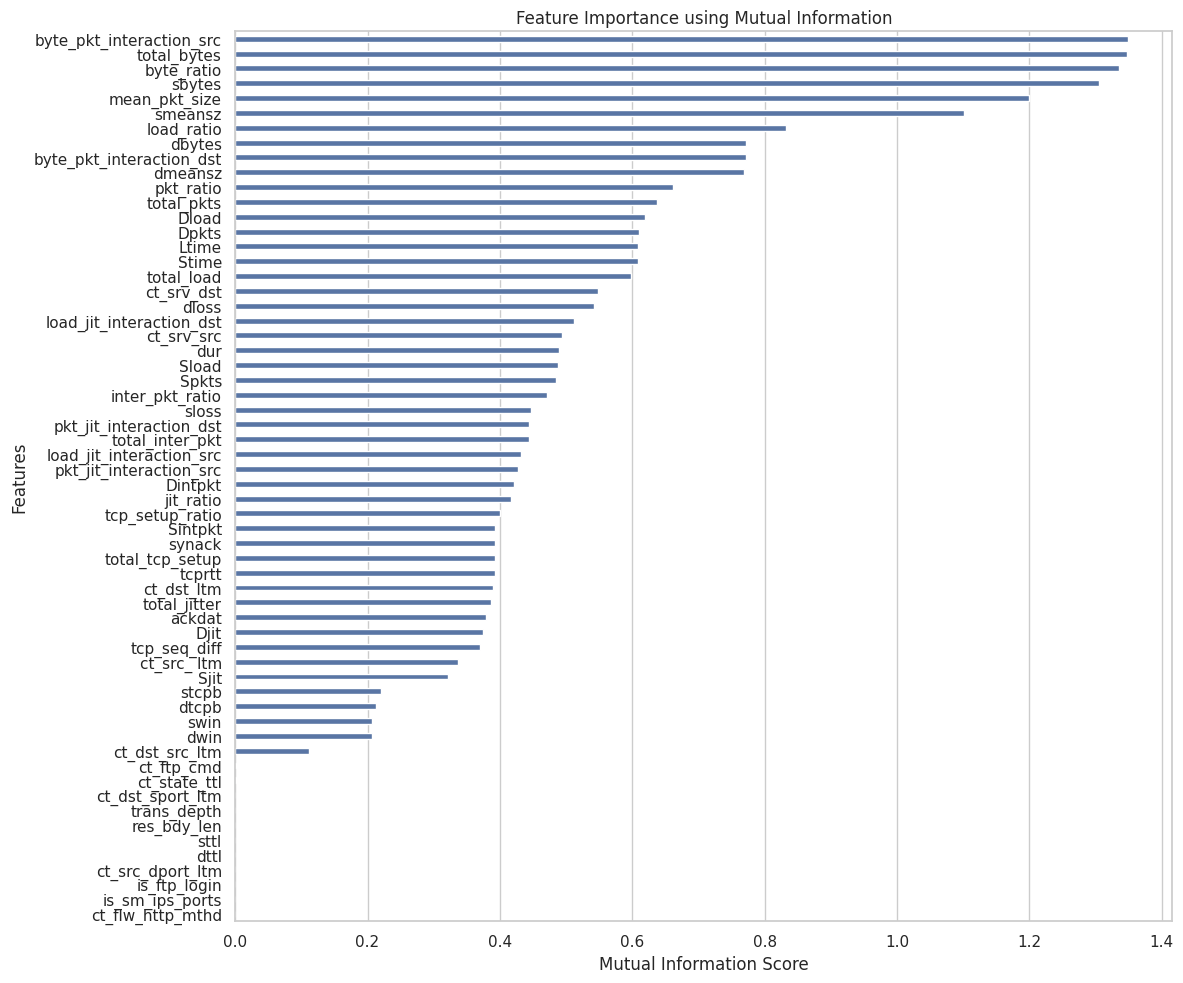

In [ ]:
mi_scores = analyze_mutual_information(X_train_resampled, y_train_resampled)

In [ ]:
# filtrar features com pontuacao < 0.01
low_score_feats = mi_scores[mi_scores['MI_Score'] < 0.01]

low_score_names = low_score_feats['Feature'].tolist()
low_score_names

['ct_ftp_cmd',
 'ct_state_ttl',
 'ct_dst_sport_ltm',
 'trans_depth',
 'res_bdy_len',
 'sttl',
 'dttl',
 'ct_src_dport_ltm',
 'is_ftp_login',
 'is_sm_ips_ports',
 'ct_flw_http_mthd']

In [ ]:
X_train_resampled.drop(low_score_names, axis=1, inplace=True)
X_test_scaled.drop(low_score_names, axis=1, inplace=True)

In [ ]:
X_train_resampled.shape

(180000, 49)

## Modelos e Avaliação

#### Classe genérica para criação, treino e teste dos modelos

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import time

In [ ]:
class ModelEvaluator:

  def __init__(self):
    self.models = {
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance']
            }
        },
        'SVM': {
            'model': SVC(),
            'params': {
                'C': [0.5, 1],
                'kernel': ['rbf']
            }
        },
        'RFC': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5]
            }
        }
    }

    self.results = {}


  def evaluate_model(self, model_name, X_train, X_test, y_train, y_test, cv=5):
    print(f"Evaluating {model_name}")
    model_dict = self.models[model_name]

    grid_search = GridSearchCV(
      model_dict['model'],
      model_dict['params'],
      cv=cv,
      n_jobs=-1,
      scoring='accuracy'
    )

    # duracao treinamento
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    # encontrar melhor modelo
    best_model = grid_search.best_estimator_

    # duracao teste
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    test_time = time.time() - start_time


    # calculo metricas
    metrics = {
      'model_name': model_name,
      'accuracy': accuracy_score(y_test, y_pred),
      'precision': precision_score(y_test, y_pred, average='weighted'),
      'recall': recall_score(y_test, y_pred, average='weighted'),
      'f1': f1_score(y_test, y_pred, average='weighted'),
      'train_time': train_time,
      'predict_time': test_time,
      'best_params': grid_search.best_params_,
      'confusion_matrix': confusion_matrix(y_test, y_pred),
      'best_model': best_model
    }

    self.results[model_name] = metrics
    return metrics


  def print_metrics(self, model_name):
    metrics = self.results[model_name]
    print(f"\nMetrics for {model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Training Time: {metrics['train_time']:.2f} seconds")
    print(f"Prediction Time: {metrics['predict_time']:.2f} seconds")
    print("\nBest Parameters:", metrics['best_params'])



#### Plots para visualização e comparação do desempenho dos modelos

In [ ]:
def plot_confusion_matrix(model_results):
  conf_matrix = model_results['confusion_matrix']
  m_name = model_results['model_name']
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix - {m_name}')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()


In [ ]:
def plot_feature_importance(model_results, feature_names):
  model = model_results['best_model']
  model_name = model_results['model_name']

  # verificar se modelo tem feat_imp
  if hasattr(model, 'feature_importances_'):
    importance = model.feature_importances_

    # ordenar por feat_imp
    inds = np.argsort(importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importance - {model_name}')
    plt.bar(range(len(importance)), importance[inds])
    plt.xticks(range(len(importance)),
              [feature_names[i] for i in inds],
              rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
  else:
    print(f"Importancia de feature nao disponivel para {model_name}")


#### Avaliação dos modelos

In [ ]:
def evaluate_models(X_train, X_test, y_train, y_test, models=None):
  """
  Evaluate multiple models and return results.

  Parameters:
  -----------
  X_train, X_test : feature matrices
  y_train, y_test : target variables
  models_to_evaluate : list of model names to evaluate (optional)
  """

  evaluator = ModelEvaluator()

  if models is None:
    models = evaluator.models.keys()

  for model_name in models:
    if model_name in evaluator.models:
      results = evaluator.evaluate_model(model_name, X_train, X_test, y_train, y_test)

      evaluator.print_metrics(model_name)

      plot_confusion_matrix(results)

  return evaluator



Evaluating SVM

Metrics for SVM:
Accuracy: 0.9630
Precision: 0.9859
Recall: 0.9630
F1 Score: 0.9730
Training Time: 8666.38 seconds
Prediction Time: 1424.75 seconds

Best Parameters: {'C': 1, 'kernel': 'rbf'}


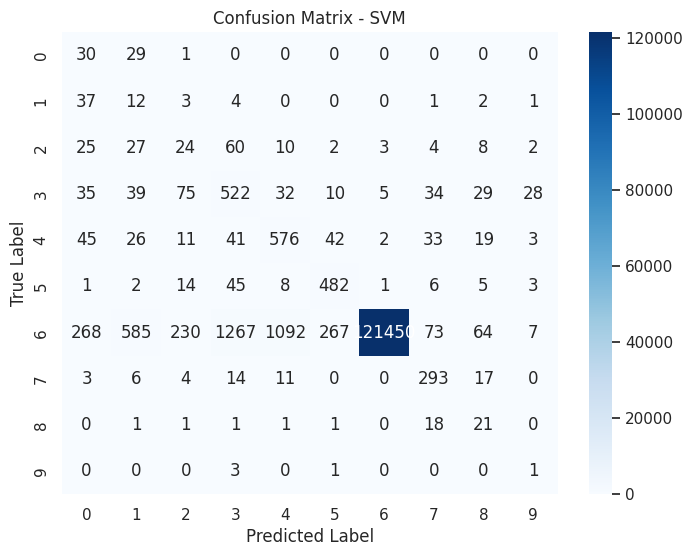

In [ ]:
evaluate_models(X_train_resampled, X_test_scaled, y_train_resampled, y_test, models=['SVM'])

#### Teste com KNN

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_resampled, y_train_resampled)
end_train = time.time()

y_pred = model.predict(X_test_scaled)
end_predict = time.time()

In [ ]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1s = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: "+ "{:.2%}".format(acc))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")

#### Resultados

In [ ]:
y_test.value_counts()

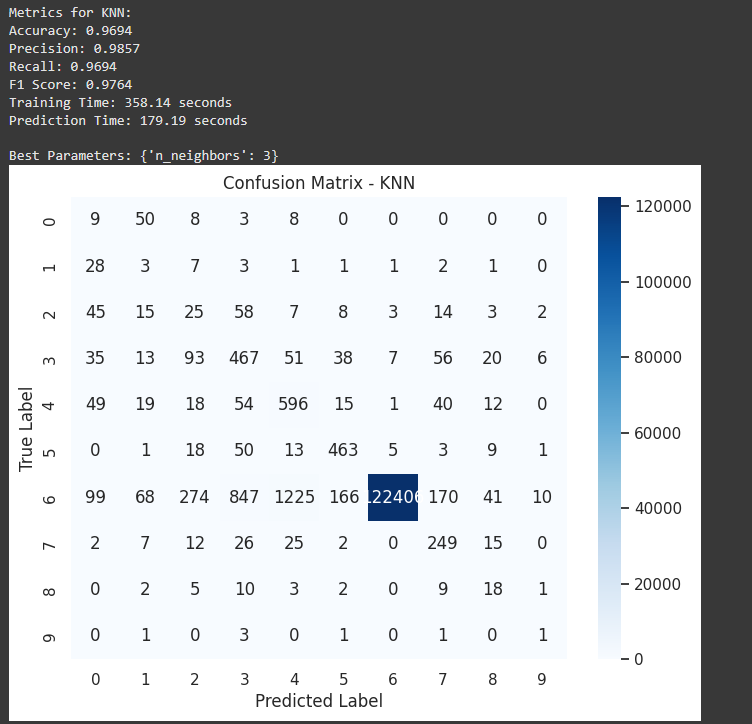

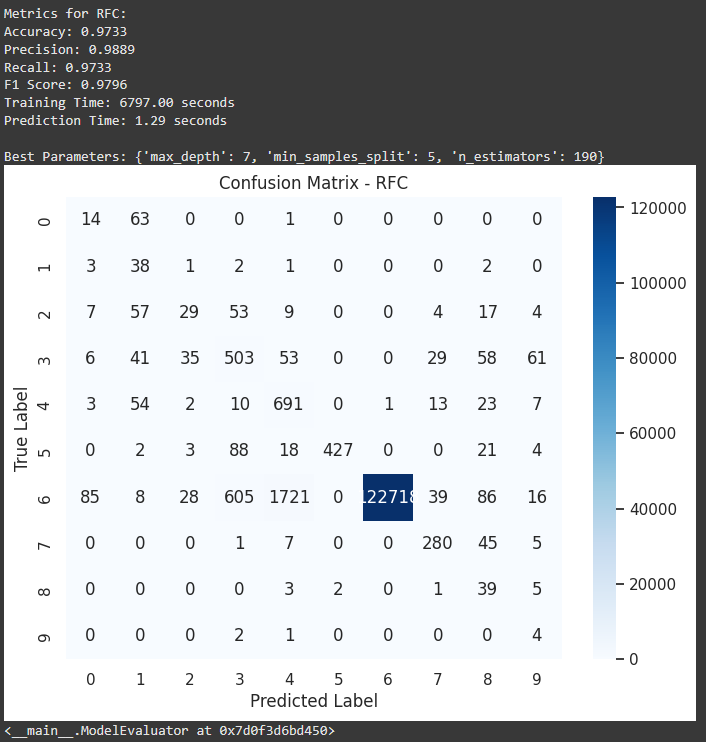